# Portfolio Regularization and Time-Series Cross-Validation
___

## 1. Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from portfolio_management.port_construction import *
from portfolio_management.port_tscv import *

excess_returns = pd.read_csv('data/excess_returns.csv', index_col='date', parse_dates=['date'])
excess_returns

,AAPL,JNJ,XOM,JPM,TSLA,PG,CSCO,KO,DIS,WMT,NKE,BA
date,,,,,,,,,,,,
2011-02-01,0.040822,0.027828,0.060002,0.040022,-0.008826,0.006024,-0.122571,0.016913,0.125177,-0.073057,0.079301,0.036301
2011-03-01,-0.013382,-0.026998,-0.011260,-0.012712,0.161499,-0.023073,-0.076045,0.037785,-0.014936,0.001272,-0.149800,0.032553
2011-04-01,0.004615,0.109165,0.045729,-0.010229,-0.005439,0.053538,0.025119,0.024223,0.000199,0.063663,0.091247,0.079095
2011-05-01,-0.006602,0.023856,-0.051295,-0.047272,0.091995,0.040886,-0.041129,-0.009669,-0.034140,0.004332,0.025841,-0.021969
2011-06-01,-0.034973,-0.002882,-0.019522,-0.053204,-0.033523,-0.051207,-0.070846,0.007172,-0.062227,-0.031313,0.065470,-0.047552
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,-0.048090,-0.039334,0.032418,-0.071679,-0.039377,-0.010733,0.105979,-0.038324,-0.063027,0.012787,-0.083045,-0.066462
2023-09-01,-0.091864,-0.034100,0.061721,-0.013369,-0.034872,-0.059360,-0.067015,-0.068766,-0.035846,-0.017401,-0.064293,-0.148817
2023-10-01,-0.007003,-0.052010,-0.104195,-0.045531,-0.201780,0.024156,-0.034753,0.012683,0.002229,0.017326,0.073947,-0.029788


## 2. Regularization Methods

*These examples demonstrate the calculation of tangency portfolio weights with shrinkage (covariance matrix regularization) and L1/L2 penalties (portfolio weight regularization)*

### 2.1 Diagonal Shrinkage
*Blends the sample covariance matrix with its diagonal (variances only) to reduce noise and improve stability.*
$$
\Sigma_{\text{shrunk}} 
= 
\alpha \,\mathrm{diag}(\Sigma)
\;+\;(1-\alpha)\,\Sigma
$$

In [4]:
diag_wts = calc_tangency_weights(
    returns=excess_returns,
    shrinkage_target="diagonal",
    shrinkage_factor=0.5
)
print("Diagonal Shrinkage Weights:")
print(diag_wts)

Diagonal Shrinkage Weights:
AAPL    0.176170
JNJ     0.173451
XOM    -0.005593
JPM     0.094705
TSLA    0.091822
PG      0.166739
CSCO    0.013466
KO      0.056398
DIS    -0.055413
WMT     0.142954
NKE     0.108352
BA      0.036949
Name: Weights, dtype: float64


### 2.2 Constant-Correlation Shrinkage
*Blends the sample covariance matrix with a constant-correlation matrix to reduce noise and improve stability. The constant-correlation matrix is constructed by replacing all off-diagonal elements of the correlation matrix with the average correlation across all asset pairs. These correlations are then scaled by the standard deviations (variances on the diagonal) of the corresponding assets.*

$$
\Sigma_{\text{shrunk}} = \alpha \Sigma_{\text{const\_corr}} + (1 - \alpha) \Sigma
$$

In [10]:
const_wts = calc_tangency_weights(
    returns=excess_returns,
    shrinkage_target="constant_correlation",
    shrinkage_factor=0.2
)
print("Constant Correlation Shrinkage Weights:")
print(const_wts)

Constant Correlation Shrinkage Weights:
AAPL    0.267823
JNJ     0.232931
XOM    -0.061425
JPM     0.191613
TSLA    0.136893
PG      0.203540
CSCO   -0.089090
KO     -0.003363
DIS    -0.234747
WMT     0.153907
NKE     0.161553
BA      0.040365
Name: Weights, dtype: float64


### 2.3 L1 and L2 Regularization
**L1 Regularization (Lasso)**: *Add a penalty $\lambda_1 \| x \|_1$ to the objective to encourage sparsity in the portfolio weights.*

**L2 Regularization (Ridge)**: *Add a penalty $\lambda_2 \| x \|_2^2$ to the objective to shrink large positions and reduce extreme weights.*

**Elastic Net**: *L1 + L2*


In [6]:
# Tangency
tangency_wts = calc_tangency_weights(returns=excess_returns)

# L1
lasso_wts = calc_tangency_weights(returns=excess_returns, l1_reg=0.01)

# L2
ridge_wts = calc_tangency_weights(returns=excess_returns, l2_reg=0.02)

# Elastic Net (L1 and L2)
elastic_net_wts = calc_tangency_weights(returns=excess_returns, l1_reg=0.01, l2_reg=0.02)

reg_df = pd.concat([tangency_wts, lasso_wts, ridge_wts, elastic_net_wts], axis=1)
reg_df.columns = ["Tangency Weights", "Lasso Weights", "Ridge Weights", "Elastic Net Weights"]
display(reg_df.round(6))

,Tangency Weights,Lasso Weights,Ridge Weights,Elastic Net Weights
AAPL,0.253423,0.249865,0.225189,0.225060
JNJ,0.198385,0.167270,0.145928,0.135711
XOM,-0.028939,-0.000000,-0.010700,-0.000000
JPM,0.238696,0.196308,0.147351,0.129012
TSLA,0.141867,0.147529,0.160040,0.165228
PG,0.221410,0.200931,0.156703,0.148603
CSCO,-0.116660,-0.067189,-0.037726,-0.008918
KO,-0.010188,-0.000000,0.049579,0.035358
DIS,-0.298954,-0.256128,-0.176328,-0.148799
WMT,0.172394,0.156759,0.142539,0.134077


## 3. TSCV Optimization
*Tune hyperparameters via time-series cross-validation to find the best l1_reg, l2_reg, or shrinkage settings for a chosen evaluation metric (e.g., Sharpe).*

### 3.1 Grid Search

In [7]:
param_dict_grid = {
    "l1_reg": np.linspace(0, 0.02, 6),
    "l2_reg": np.linspace(0, 1.0, 6),
    "shrinkage_factor": np.linspace(0, 0.5, 3),
    "shrinkage_target": ["diagonal", "constant_correlation"]
}

result_grid = tune_regularization_tscv(
    returns=excess_returns,
    param_dict=param_dict_grid,
    method="grid",
    eval_metric="sharpe",  # maximize sharpe
    aggregator="mean",
    window_type="rolling",
    train_window=36,   # months
    test_window=12,    # months
    step_size=12,
    objective_type="max_sharpe"
)

# tangency weights with regularization parameters optimized by grid search
best_grid_params = result_grid["best_params"]
grid_wts = calc_tangency_weights(returns=excess_returns, **best_grid_params)

print("Grid Search Best Params:", result_grid["best_params"])
print(f"Grid Search Best Score: {result_grid["best_score"]:.4f}")
print('Weights:')
print(grid_wts)


Grid Search Best Params: {'l1_reg': np.float64(0.0), 'l2_reg': np.float64(1.0), 'shrinkage_target': 'diagonal', 'shrinkage_factor': np.float64(0.5)}
Grid Search Best Score: 1.1160
Weights:
AAPL    0.137677
JNJ     0.059797
XOM     0.037891
JPM     0.080812
TSLA    0.244874
PG      0.056113
CSCO    0.059131
KO      0.045413
DIS     0.044581
WMT     0.061458
NKE     0.087556
BA      0.084696
Name: Weights, dtype: float64


### 3.2 Bayesian Search

In [8]:
param_dict_bayes = { 
    "l1_reg": (0, 0.2),
    "l2_reg": (0, 1.0),
    "shrinkage_factor": (0, 0.5),
    "shrinkage_target": ["diagonal", "constant_correlation"]
}

result_bayes = tune_regularization_tscv(
    returns=excess_returns,
    param_dict=param_dict_bayes,
    method="bayes",
    eval_metric="mean_return",
    aggregator="mean",
    window_type="rolling",
    train_window=36,
    test_window=12,
    step_size=12,
    method_config={"n_calls": 30, "random_state": 123},
    objective_type="max_sharpe"
)

# tangency weights with regularization parameters optimized by bayesian search
best_bayes_params = result_bayes["best_params"]
bayes_wts = calc_tangency_weights(returns=excess_returns, **best_bayes_params)

print("Bayes Search Best Params:", result_bayes["best_params"])
print(f"Bayes Search Best Score: {result_bayes["best_score"]:.4f}")
print('Weights:')
print(bayes_wts)


Bayes Search Best Params: {'l1_reg': 0.2, 'l2_reg': 1.0, 'shrinkage_target': np.str_('diagonal'), 'shrinkage_factor': 0.5}
Bayes Search Best Score: 0.1806
Weights:
AAPL    0.153266
JNJ     0.051185
XOM     0.024697
JPM     0.080368
TSLA    0.296297
PG      0.046153
CSCO    0.052127
KO      0.032865
DIS     0.034413
WMT     0.053210
NKE     0.088464
BA      0.086956
Name: Weights, dtype: float64


### 3.3 Visualization

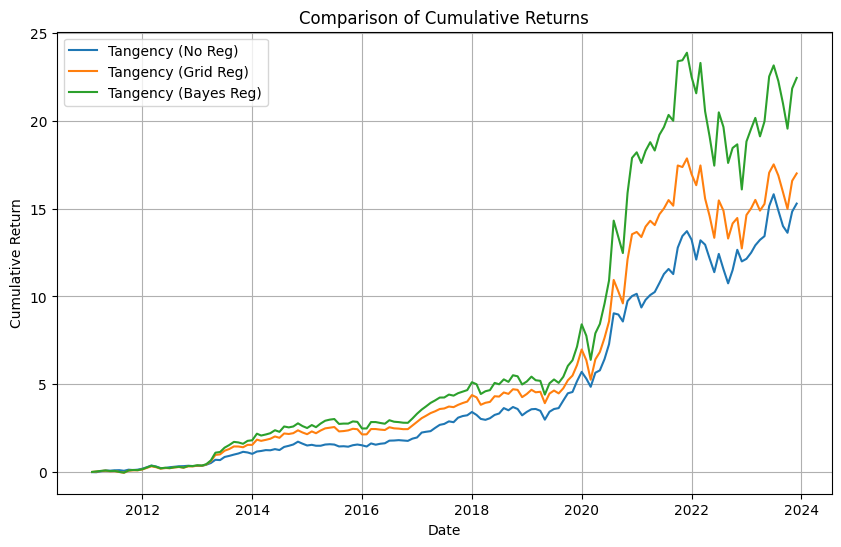

In [9]:
# tangency weights with no regularization
tangency_wts = calc_tangency_weights(returns=excess_returns)

# calculate cumulative returns for each portfolio
cumulative_no_reg = (1 + (excess_returns @ tangency_wts)).cumprod() - 1
cumulative_grid   = (1 + (excess_returns @ grid_wts)).cumprod() - 1
cumulative_bayes  = (1 + (excess_returns @ bayes_wts)).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(cumulative_no_reg.index, cumulative_no_reg, label="Tangency (No Reg)")
plt.plot(cumulative_grid.index, cumulative_grid, label="Tangency (Grid Reg)")
plt.plot(cumulative_bayes.index, cumulative_bayes, label="Tangency (Bayes Reg)")
plt.title("Comparison of Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="best")
plt.grid(True)
plt.show()
